In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import pickle
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from keras import layers
from keras import regularizers
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import csv
from keras import models

In [48]:
data = pd.read_csv("dataset/data.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

In [3]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
# The top results have the positive results while the bottom results have negative results

In [6]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [7]:
print('lenght of data is', len(data))

lenght of data is 1599999


In [8]:
# The overall dataset is quite large. Therefore a portion of this data shall be used.

In [9]:
data.shape

(1599999, 6)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
np.sum(data.isnull().any(axis=1))

0

In [12]:
# There are no null values. Therefore, missing value treatment is not needed.

In [13]:
# We only need the text and the label column. Therefore only those 2 columns are selected

data=data[['text','label']]

In [14]:
# Values for label are 0 and 4. The 4 values are changed to 1

data['label'][data['label']==4]=1

In [15]:
# We seperate out the positive and negative samples and select 20000 from each. 
# The original dataset is too big. Therefore, having a smaller sample helps in increasing training speed
# The original dataset is also imbalanced. Therefore, taking 20000 values from both hepls make the dataset balanced.
# The number of samples can be increased to improve accuracy.

data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

data_pos = data_pos.iloc[:int(30000)]
data_neg = data_neg.iloc[:int(30000)]

# Merging the data

data = pd.concat([data_pos, data_neg])

In [16]:
# We convert the text to lowercase

data['text']=data['text'].str.lower()

In [17]:
data.tail()

,text,label
29995,oh ffs! i've been here all fucking day. why de...,0
29996,leaving britney-just found out jon from new ki...,0
29997,"@neomic i havta' go pee, but im scared to walk...",0
29998,nooooooooooooooo!!!!!! school today. but the w...,0
29999,back to school tomorow,0


In [18]:
# The data needs to be cleaned. 

stopwords_list = stopwords.words('english')

", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [19]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
#data['text'].head()



english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
#data['text'].tail()



def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
#data['text'].tail()



def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

data['text']= data['text'].apply(lambda x: cleaning_email(x))
#data['text'].tail()



def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
#data['text'].tail()



def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
#data['text'].tail()

In [20]:
data.head()

,text,label
799999,love healthuandpets u guys r best,1
800000,im meting one besties tonight cant wait girl talk,1
800001,darealsunisakim thanks twiter ad sunisa got me...,1
800002,sick realy cheap hurts much eat real fod plus ...,1
800003,lovesbroklyn efect everyone,1


In [21]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [23]:
X=data['text']
y=[]

for i in range(len(data)):
  l=[0,0]
  temp=data.iloc[i,1]
  l[temp-1]=1
  y.append(l)

print(y[0])
print(y[-1])

# [1,0] for positive emotion, [0,1] for negative emotion

[1, 0]
[0, 1]


In [24]:
max_len=0
min_len=1000
sum_len=0
avg_len=0


for i in X:
    if len(i)>max_len:
        max_len=len(i)
    if len(i)< min_len:
        min_len=len(i)
    sum_len=sum_len+len(i)
avg_len=sum_len/len(X)
print(max_len)
print(min_len)
print(sum_len)
print(avg_len)
print(len(X))

39
0
466831
7.780516666666666
60000


In [25]:
max_len = 100
num_words = 2000
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [26]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [27]:
sequences

[[13, 23, 133, 300, 93],
 [1, 524, 15, 63, 10, 76, 193, 234],
 [32, 29, 478, 12, 235, 103, 1996, 1247],
 [85, 18, 280, 35, 274, 309, 281, 747, 108, 65, 1107],
 [111],
 [198, 1476, 18, 1268, 32, 237, 62],
 [131, 121, 659],
 [554, 39, 38, 14, 989, 5, 13, 103],
 [501, 135, 539, 737, 142, 29],
 [320, 555, 1038, 1093],
 [360, 3, 69, 117, 1248, 107, 1134, 464, 56, 379, 70, 216],
 [824, 189, 445, 1184, 13, 103],
 [51, 840, 4, 600, 28],
 [273, 15, 92, 156, 180, 340, 203, 182, 990, 728, 131],
 [65, 123, 1039, 345, 469, 293, 48, 68, 4, 90],
 [1094, 1941, 26, 412],
 [18, 17, 27, 74, 1377, 1377],
 [1305, 414, 279],
 [1249, 1477, 872, 1, 139, 63, 375, 252],
 [829, 191, 268, 563, 55, 20, 29, 887],
 [342, 1269, 1843, 32, 1338],
 [8, 52, 344, 111, 279, 544],
 [1025, 222, 33],
 [],
 [795, 478, 11],
 [84, 1, 26, 991, 20, 248, 321, 248],
 [1135],
 [1710],
 [289, 121, 851, 375],
 [275, 63, 166, 90, 947, 1801, 367, 924],
 [70, 641, 14, 277],
 [142, 8, 52, 95, 72, 107, 1134, 276],
 [95, 505, 1430, 24, 12, 3

In [28]:
list = ['This is the best day of my life', 'I feel like dying','I want to die I am a bad person','I feel like killing myself','I am happy','I am sad','I am very happy']
sequences = tok.texts_to_sequences(list)
print(sequences)
input_to_predict = sequence.pad_sequences(sequences, maxlen=100)
#print(input_to_predict)
input_to_predict = np.array(input_to_predict)
#print(input_to_predict)

[[390, 355, 861, 93, 3, 315, 1345, 106], [381, 5, 831], [381, 25, 56, 844, 381, 146, 952, 57, 461], [381, 5, 721], [381, 146], [381, 146, 54], [381, 146, 1432]]


In [29]:
df = {'X': X, 'y': y}

dataset = pd.DataFrame(df)

dataset.to_csv('dataset.csv')

In [30]:
sequences_matrix.shape

(60000, 100)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=2)

In [32]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [33]:
model = Sequential()
model.add(layers.Embedding(2000, 40, input_length=max_len))
model.add(layers.LSTM(64))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(2,activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd, metrics=['accuracy'])

C:\Users\Yash\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 40)           80000     
                                                                 
 lstm (LSTM)                 (None, 64)                26880     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 164,802
Trainable params: 164,802
Non-trai

In [35]:
history=model.fit(X_train, y_train, epochs=40,validation_data=(X_test, y_test))

Epoch 1/40
1500/1500 [==============================] - 87s 57ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6929 - val_accuracy: 0.5027
Epoch 2/40
1500/1500 [==============================] - 97s 65ms/step - loss: 0.6915 - accuracy: 0.5251 - val_loss: 0.6885 - val_accuracy: 0.5366
Epoch 3/40
1500/1500 [==============================] - 95s 63ms/step - loss: 0.6275 - accuracy: 0.6369 - val_loss: 0.5589 - val_accuracy: 0.7186
Epoch 4/40
1500/1500 [==============================] - 83s 56ms/step - loss: 0.5300 - accuracy: 0.7370 - val_loss: 0.5249 - val_accuracy: 0.7398
Epoch 5/40
1500/1500 [==============================] - 85s 56ms/step - loss: 0.5051 - accuracy: 0.7535 - val_loss: 0.5073 - val_accuracy: 0.7483
Epoch 6/40
1500/1500 [==============================] - 77s 52ms/step - loss: 0.4957 - accuracy: 0.7595 - val_loss: 0.5124 - val_accuracy: 0.7486
Epoch 7/40
1500/1500 [==============================] - 79s 53ms/step - loss: 0.4908 - accuracy: 0.7628 - val_loss: 0.5087 -

In [36]:
list = ['This is the best day of my life', 'I feel like dying','I want to die I am a bad person','I feel like killing myself','I am happy','I am sad','I am very happy']

sequences = tok.texts_to_sequences(list)
testing_sequences = sequence.pad_sequences(sequences,maxlen=max_len)

y_samples = np.array(testing_sequences)
#model.predict(y_samples)

In [37]:
print(list)
print(model.predict(y_samples))

['This is the best day of my life', 'I feel like dying', 'I want to die I am a bad person', 'I feel like killing myself', 'I am happy', 'I am sad', 'I am very happy']
[[9.9922478e-01 7.7517715e-04]
 [4.4469060e-03 9.9555308e-01]
 [6.1749681e-03 9.9382508e-01]
 [8.1927866e-01 1.8072139e-01]
 [7.8447735e-01 2.1552265e-01]
 [4.7054000e-05 9.9995291e-01]
 [9.9896765e-01 1.0323352e-03]]


In [38]:
weigh= model.get_weights();    pklfile= r"C:\Users\Yash\Desktop\Final Year Project\New Dataset Machine learning model\modelweights.pkl"
try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()

3

In [39]:
model.save("model.h5")

3

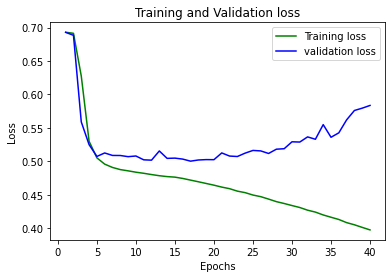

In [45]:
loss_train = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])
epochs = np.array(range(1,41))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

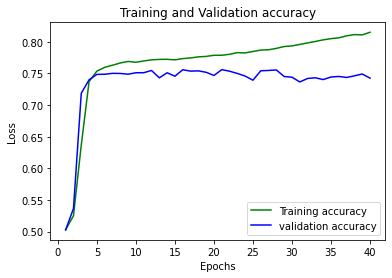

In [49]:
loss_train = np.array(history.history['accuracy'])
loss_val = np.array(history.history['val_accuracy'])
epochs = np.array(range(1,41))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()